In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from scipy import stats
from torch import Tensor

from bayesian_stats.mcmc import Bounds, CumulativeDistribution, initialize_samples, get_sample_log_prob

# Beta-binomial example
What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?What is the probability a coin is materially biases towards heads ($P(heads) > 52.5\%$), given we flipped it 250 times and observed 140 heads?

We'll set our prior to convey significant skepticism the coin is biased: $P(heads) \sim beta(a=100, b=100)$

## Analytic solution using beta-binomial conjugate

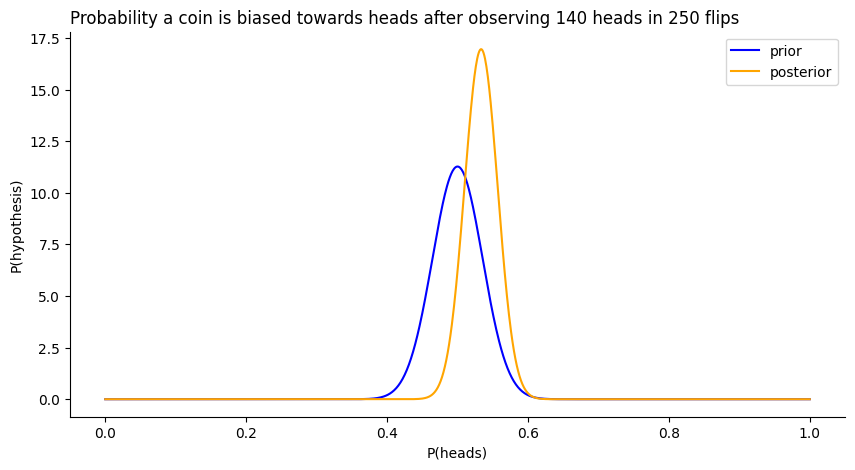

In [2]:
prior = dist.Beta(100, 100)
posterior = dist.Beta(100 + 140, 100 + 250 - 140)
_, ax = plt.subplots(figsize=(10,5))

p_heads = torch.linspace(0, 1, 1001)
ax.plot(p_heads, torch.exp(prior.log_prob(p_heads)), label="prior", color="blue")
ax.plot(p_heads, torch.exp(posterior.log_prob(p_heads)), label="posterior", color="orange")
ax.spines[['right', 'top']].set_visible(False)
ax.set_title(
    "Probability a coin is biased towards heads after observing 140 heads in 250 flips",
    loc='left', 
    fontdict={'fontsize': 12}
)
ax.set_xlabel("P(heads)")
ax.set_ylabel("P(hypothesis)")
ax.legend()

## Approximate solution using MCMC

In [6]:
def prior(a: float, b: float, p: Tensor) -> Tensor:
    return dist.Beta(a, b).log_prob(p)

def likelihood(p: Tensor, n: int, k: int) -> Tensor:
    return dist.Binomial(total_count=n, probs=p).log_prob(torch.tensor(k))

In [7]:
samples = initialize_samples([(0,1)], num_samples=2**10)
samples

tensor([[0.6352],
        [0.0850],
        [0.4863],
        ...,
        [0.4852],
        [0.0842],
        [0.6361]])

In [8]:
get_sample_log_prob(
    parameters=["p"],
    samples=samples,
    likelihood=partial(likelihood, n=250, k=140),
    prior=partial(prior, a=100, b=100),
)

tensor([ -11.0544, -299.4460,   -3.3569,  ...,   -3.4506, -301.6765,
         -11.2217])

In [ ]:
def run_mcmc(
    parameter_bounds: dict[str, Bounds],
    likelihood: Callable[[dict[str, Tensor]], Tensor],
    prior: Callable[[dict[str, Tensor]], Tensor],
    *,
    num_samples: int = 1_024,
    num_iter: int = 1_000,
    proposal_width: float = 0.10,
    device: torch.device | None = None,
    dtype: torch.dtype | None = torch.float32,
    seed: int | None = None,
):
    
    # Initialize samples
    samples = initialize_samples(
        bounds=parameter_bounds.values(),
        num_samples=num_samples,
        device=device,
        dtype=dtype,
        seed=seed,
    )
    
    # Evaluate samples
    _eval_fxn = partial(
        get_sample_log_prob, 
        parameters=list(parameter_bounds.keys()),
        likelihood=likelihood,
        prior=prior
    )
    log_probs = _eval_fxn(samples)

In [12]:
cdist = CumulativeDistribution(samples)
sample_cprobs = cdist.get_prob(samples)
sample_cprobs

tensor([[0.6348],
        [0.0850],
        [0.4854],
        ...,
        [0.4844],
        [0.0840],
        [0.6357]])